# 0100 ベースラインモデル構築と評価
1. 多重共線性への対処：面積関連変数/フラグや古さ指標など、相関の高い変数が多いため、L2正則化が適切
2. 解釈のしやすさ：線形モデルやからモデルの解釈がしやすい。どの特徴量が重要かが係数から分かる
3. 計算効率：非線形モデルに比べて学習が速いから、素早く結果を確認できる
4. 過学習の防止：正則化パラメータαを調整することで、過学習を防げる

以上の利用から、Ridge回帰をベースラインモデルとして選定。

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

from constants import *

plt.style.use('ggplot')
sns.set_palette('rocket')

## 0. データ取得から標準化まで

In [2]:
all_data = pd.read_csv(os.path.join(RAW_PATH, '0000_train_w_fs.csv'), index_col=0)
all_data.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,log_TotalBsmtSF,log_GrLivArea,log_LotArea,log_total_sf,house_age,remod_age,yrs_before_remod,is_remodeled,built_era,year_price
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,6.753438,7.444833,9.042040,7.850493,5,5,0,0,post-2000,227387.363668
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,7.141245,7.141245,9.169623,7.833996,31,31,0,0,60-80,166794.831439
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,6.825460,7.488294,9.328212,7.903596,7,6,1,0,post-2000,223657.905932
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,6.629363,7.448916,9.164401,7.813592,91,36,55,0,1900-1940,124018.557143
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,7.044033,7.695758,9.565284,8.114923,8,8,0,0,80-2000,222266.190377


### 訓練と検証に使用するデータを作成
フラグと、すでに標準化されているものを除いて標準化

In [3]:
cols_to_scale = [
    'log_total_sf', # 立地、広さ（log）
    'house_age', 'remod_age', 'yrs_before_remod', 'year_price', # 古さに関する指標
    ] 

cols_not_scale = ['neighbor_log_price_stdscaled', 'has_2nd', 'has_bsmt', 'has_garage', 'has_pool',
                  'OverallQual_weight', 'OverallCond_weight', 'ExterQual_weight', 'ExterCond_weight', 'KitchenQual_weight'] # 設備のフラグ、スケール済み変数

data = all_data[cols_not_scale]

data_to_fit = all_data[cols_to_scale]

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

data[cols_to_scale] = scaler.fit_transform(data_to_fit)

target = all_data['log_price'] # 目的変数

data.head() # 説明変数

/var/folders/rk/9smfwdqx2cvdqr4qd3693stc0000gn/T/ipykernel_26393/4232957005.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[cols_to_scale] = scaler.fit_transform(data_to_fit)
/var/folders/rk/9smfwdqx2cvdqr4qd3693stc0000gn/T/ipykernel_26393/4232957005.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[cols_to_scale] = scaler.fit_transform(data_to_fit)
/var/folders/rk/9smfwdqx2cvdqr4qd3693stc0000gn/T/ipykernel_26393/4232957005.py:16: SettingWithCopyWarning: 
A value is trying to be set on a c

,neighbor_log_price_stdscaled,has_2nd,has_bsmt,has_garage,has_pool,OverallQual_weight,OverallCond_weight,ExterQual_weight,ExterCond_weight,KitchenQual_weight,log_total_sf,house_age,remod_age,yrs_before_remod,year_price
Id,,,,,,,,,,,,,,,
1,0.392476,1,1,1,0,0.491938,1.125140,0.473100,0.791019,0.421785,0.151951,-1.043259,-0.869941,-0.555742,0.875194
2,0.922961,0,1,1,0,0.136047,0.453155,-0.398789,0.791019,-0.545426,0.099298,-0.183465,0.390141,-0.555742,-0.333317
3,0.392476,1,1,1,0,0.491938,1.125140,0.473100,0.791019,0.421785,0.321443,-0.977121,-0.821476,-0.514873,0.800811
4,0.518880,1,1,1,0,0.491938,1.125140,-0.398789,0.791019,0.421785,0.034171,1.800676,0.632464,1.692084,-1.186486
5,1.897997,1,1,1,0,0.877136,1.125140,0.473100,0.791019,0.421785,0.995943,-0.944052,-0.724547,-0.555742,0.773053


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1460 entries, 1 to 1460
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   neighbor_log_price_stdscaled  1460 non-null   float64
 1   has_2nd                       1460 non-null   int64  
 2   has_bsmt                      1460 non-null   int64  
 3   has_garage                    1460 non-null   int64  
 4   has_pool                      1460 non-null   int64  
 5   OverallQual_weight            1460 non-null   float64
 6   OverallCond_weight            1460 non-null   float64
 7   ExterQual_weight              1460 non-null   float64
 8   ExterCond_weight              1460 non-null   float64
 9   KitchenQual_weight            1460 non-null   float64
 10  log_total_sf                  1460 non-null   float64
 11  house_age                     1460 non-null   float64
 12  remod_age                     1460 non-null   float64
 13  yrs_befo

## 1. モデル構築：Ridge回帰
### 説明変数と目的変数、訓練データと検証データに分割

In [5]:
from sklearn.model_selection import train_test_split

X = data
y = target

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=87)


### Ridge回帰モデルで学習
$\alpha=0.25$<br>
スコアは対数価格についてのRMSE

In [6]:
from sklearn.linear_model import Ridge

alpha = 1

base_model = Ridge(alpha=alpha)

base_model.fit(X_train, y_train)

y_pred = base_model.predict(X_val)


from sklearn.metrics import root_mean_squared_error, r2_score

rmse = root_mean_squared_error(y_val, y_pred)
r2 = r2_score(y_val, y_pred)

print(f"Ridge Regr. (alpha={alpha})")
print(f'RMSE: {rmse}')
print(r2)

Ridge Regr. (alpha=1)
RMSE: 0.15459721285860753
0.8646681475071424


### 当てはまり度合いを確認
予測と実測の散布図、回帰線（信頼区間95%）を表示

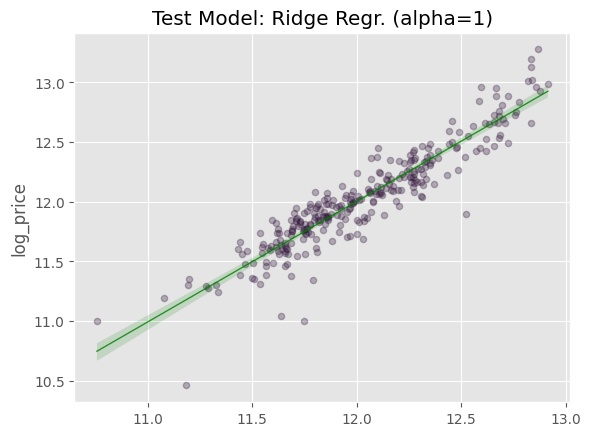

In [7]:
sns.regplot(x=y_pred, y=y_val, scatter_kws={'s': 20, 'alpha': 0.3}, line_kws={'color': 'green', 'lw': 1, 'alpha': 0.8})
plt.title(f"Test Model: Ridge Regr. (alpha={alpha})")
plt.show()


## 2. モデル評価
### 特徴量の貢献度を可視化

/Users/automatedtomato/github.com/automatedtomato/kaggle-house-prices/notebooks/utils/utils.py:113: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='importance', y='feature', data=importance, palette=colors)


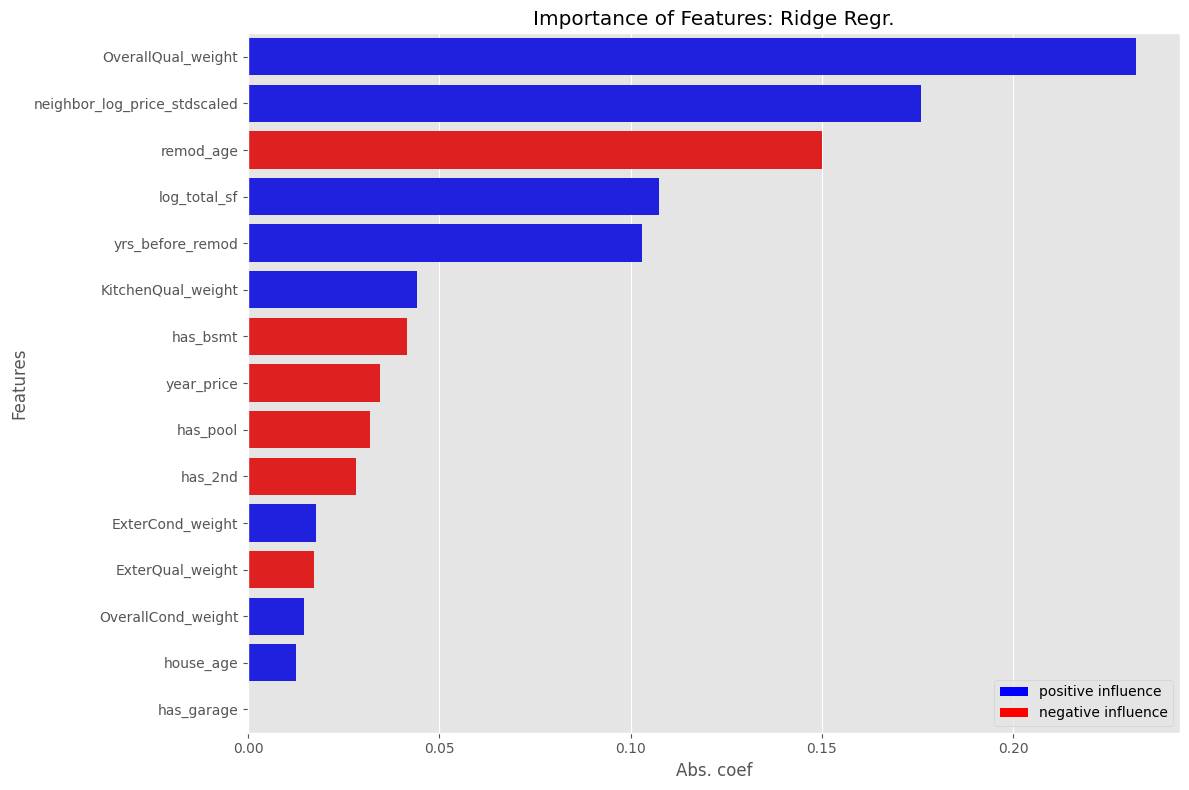

In [9]:
features = [
    'log_total_sf',
    'house_age', 'remod_age', 'yrs_before_remod', 'year_price',
    'OverallQual_weight', 'OverallCond_weight', 'ExterQual_weight', 'ExterCond_weight', 'KitchenQual_weight',
    'neighbor_log_price_stdscaled', 
    'has_2nd', 'has_bsmt', 'has_garage', 'has_pool'
    ]

from utils import plot_feature_importance

# 重要度プロット呼び出し
importance_df = plot_feature_importance(base_model, features, 'coef', "Importance of Features: Ridge Regr.")

In [10]:
importance_df.reset_index(drop=True)

,feature,importance,coefficient
0,OverallQual_weight,0.232020,0.232020
1,neighbor_log_price_stdscaled,0.176011,0.176011
2,remod_age,0.149921,-0.149921
3,log_total_sf,0.107298,0.107298
4,yrs_before_remod,0.102878,0.102878
5,KitchenQual_weight,0.044179,0.044179
6,has_bsmt,0.041520,-0.041520
7,year_price,0.034426,-0.034426
8,has_pool,0.031773,-0.031773
9,has_2nd,0.028306,-0.028306


### 貢献度からわかること
- 品質・立地・広さ・古さが特に貢献
- 負の貢献をしている以外な変数がある（二階の有無、プールの有無、建築年代ごとの係数）

### 削除対象
- ガレージの有無、築年数、Cond系、year_price、総面積以外の広さの指標

### 貢献度の高い変数順に、相関行列と偏相関行列を作成

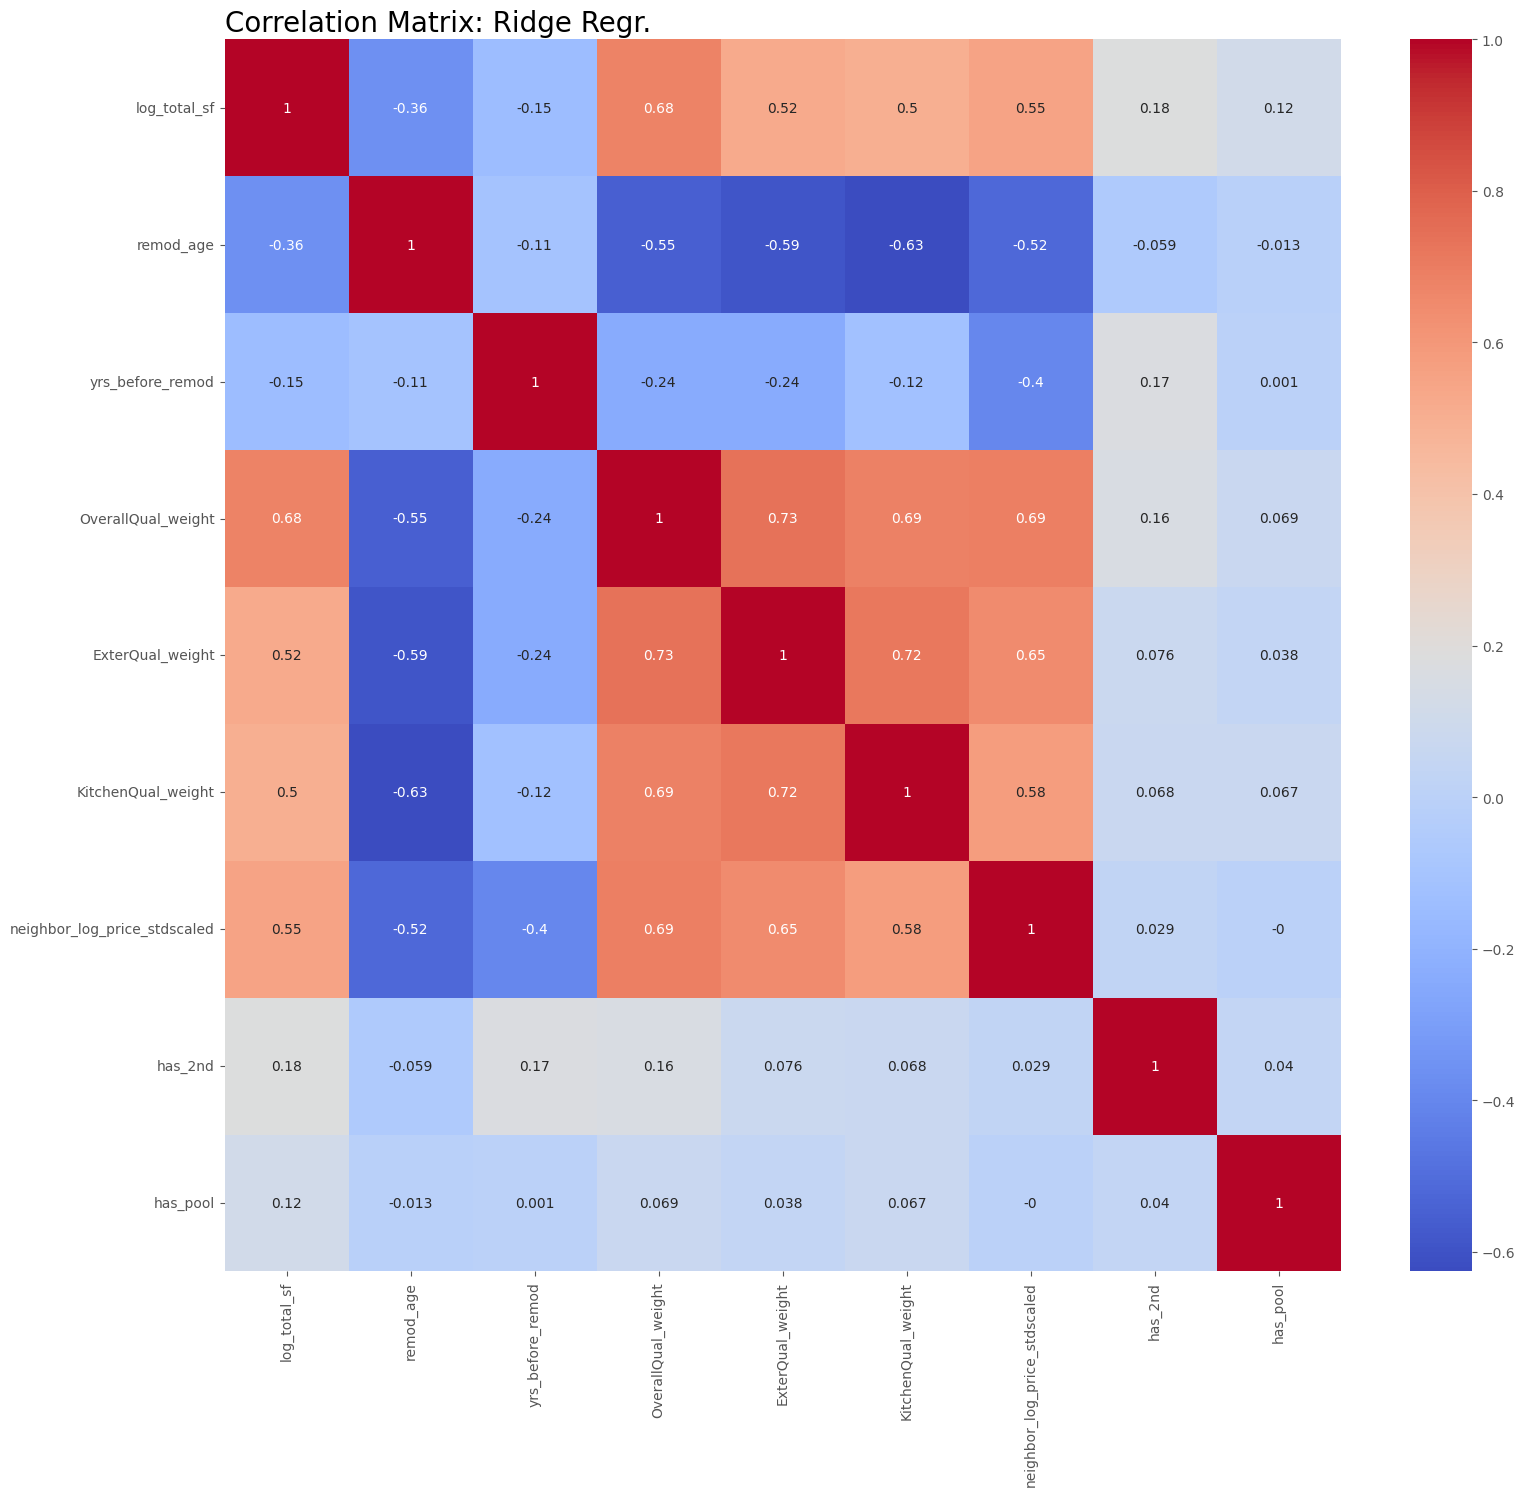

In [11]:
important_cols = ['log_total_sf',
    'remod_age', 'yrs_before_remod',
    'OverallQual_weight', 'ExterQual_weight', 'KitchenQual_weight',
    'neighbor_log_price_stdscaled', 
    'has_2nd','has_pool']

corr_mat = data[important_cols].corr().round(3)

plt.figure(figsize=(18, 16))
sns.heatmap(data=corr_mat, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix: Ridge Regr.', fontsize=20, loc='left')
plt.savefig(os.path.join(IMAGE_PATH, '0101_corr_matrix.png'))
plt.show()

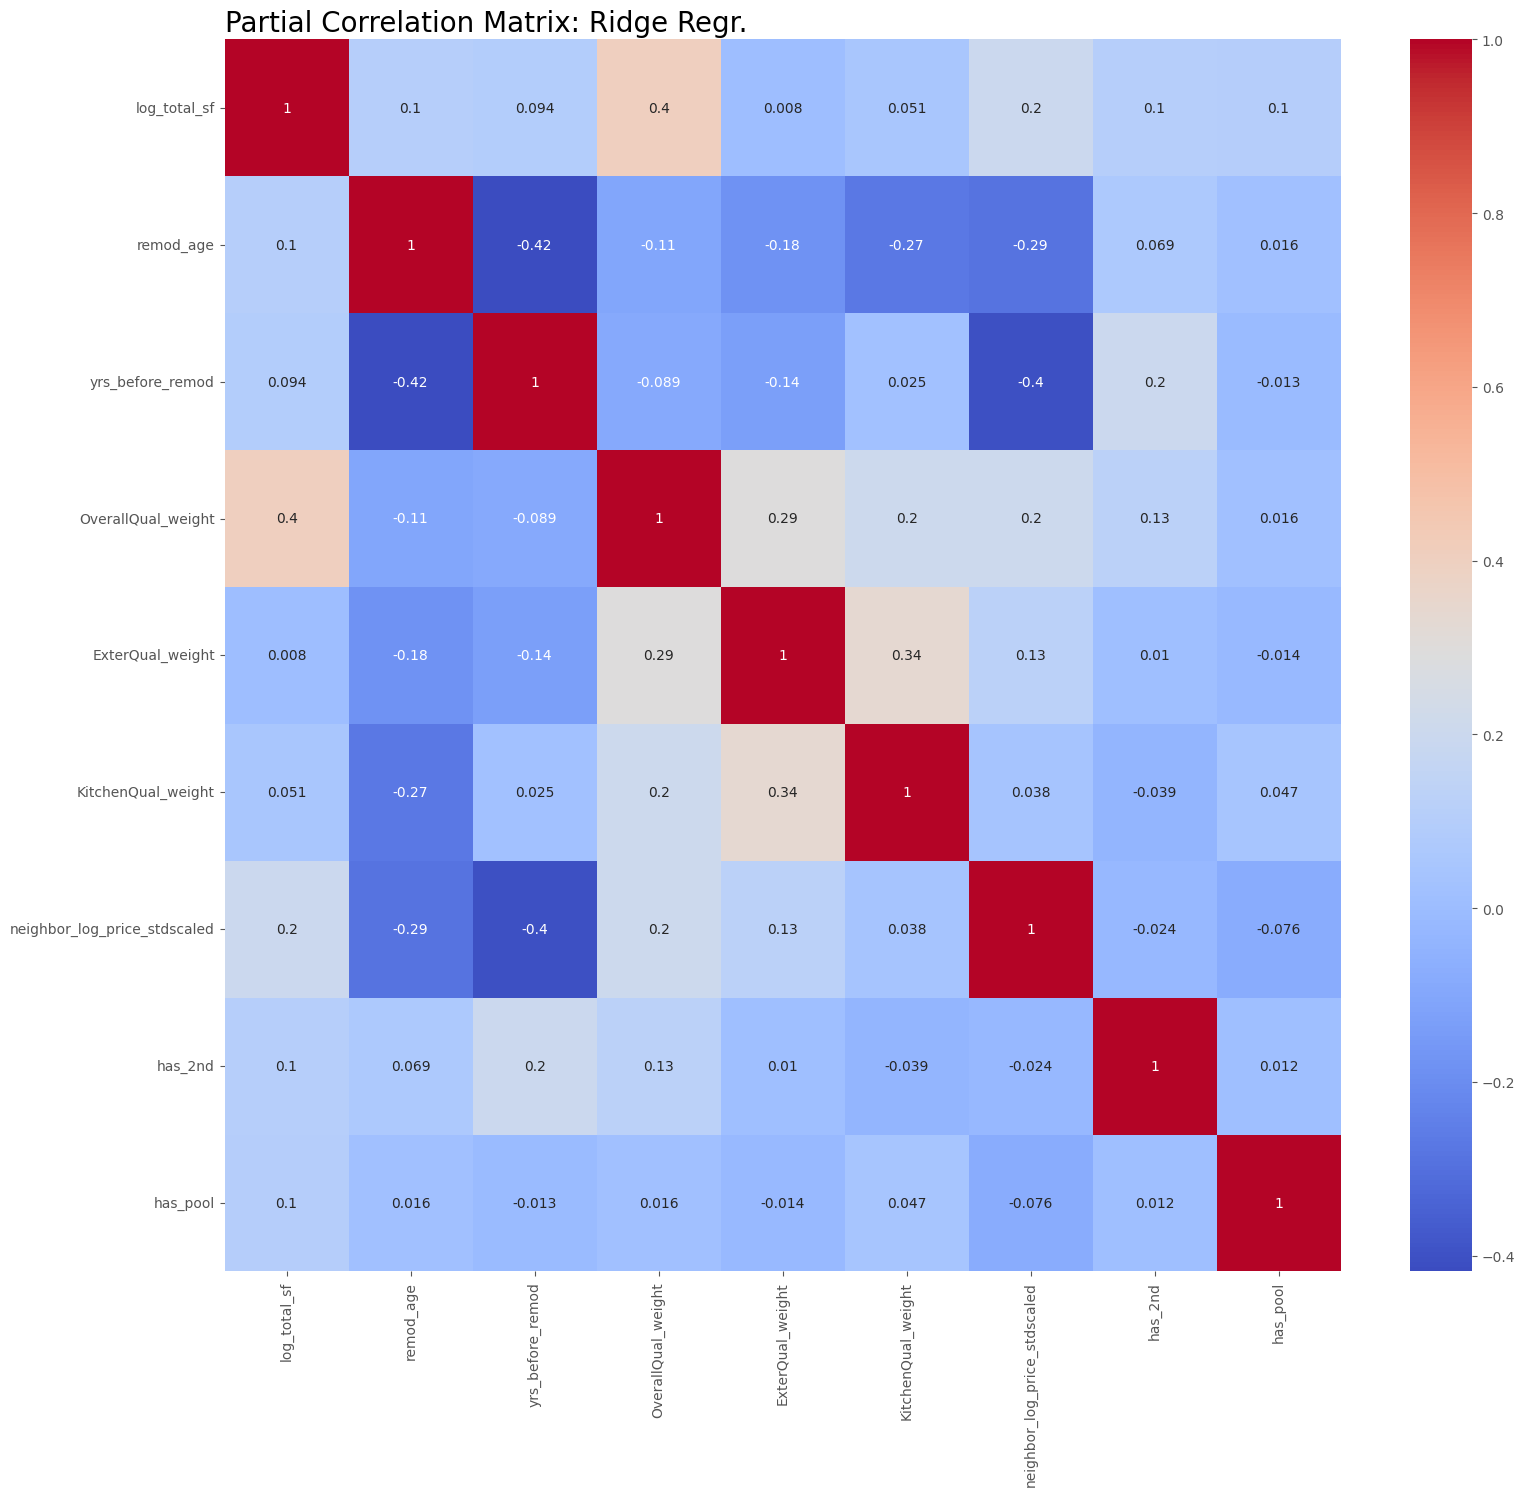

In [12]:
import pingouin as pg

pcorr_mat = pg.pcorr(data[important_cols]).round(3)

plt.figure(figsize=(18, 16))
sns.heatmap(data=pcorr_mat, annot=True, cmap='coolwarm')
plt.title('Partial Correlation Matrix: Ridge Regr.', fontsize=20, loc='left')
plt.savefig(os.path.join(IMAGE_PATH, '0102_pcorr_matrix.png'))
plt.show()

### 相関図・編相関図から考えられること
- 相関は正だが偏相関が負の変数ペア：第三の変数の影響を受けて見かけ上の正の相関が出ている可能性が高い
- 強い相関があるのに偏相関がゼロ近い：共通の変数に支配されていて、独立してみると関係がない可能性あり
- 相関も偏相関も高い：それらについてはまとめることが可能かも
- 相関も偏相関も低い：独立と仮定

#### より具体的に
- 「全体の品質」と「広さ」には本質的な関係がありそう（相関・偏相関ともにある程度ある）
- キッチンの品質と外装の品質についても、なんらかの関係が見出せる（相関・偏相関ともにある程度ある）


#### 次のステップ：
- 年代に関する指標は明らかに重複しているため、代表的な`remod_age`のみを使用
- 広さに関しても、代表的な`log_total_sf`のみで再度学習
- 広さと品質は立地（高級住宅街など）が説明しているのでは？

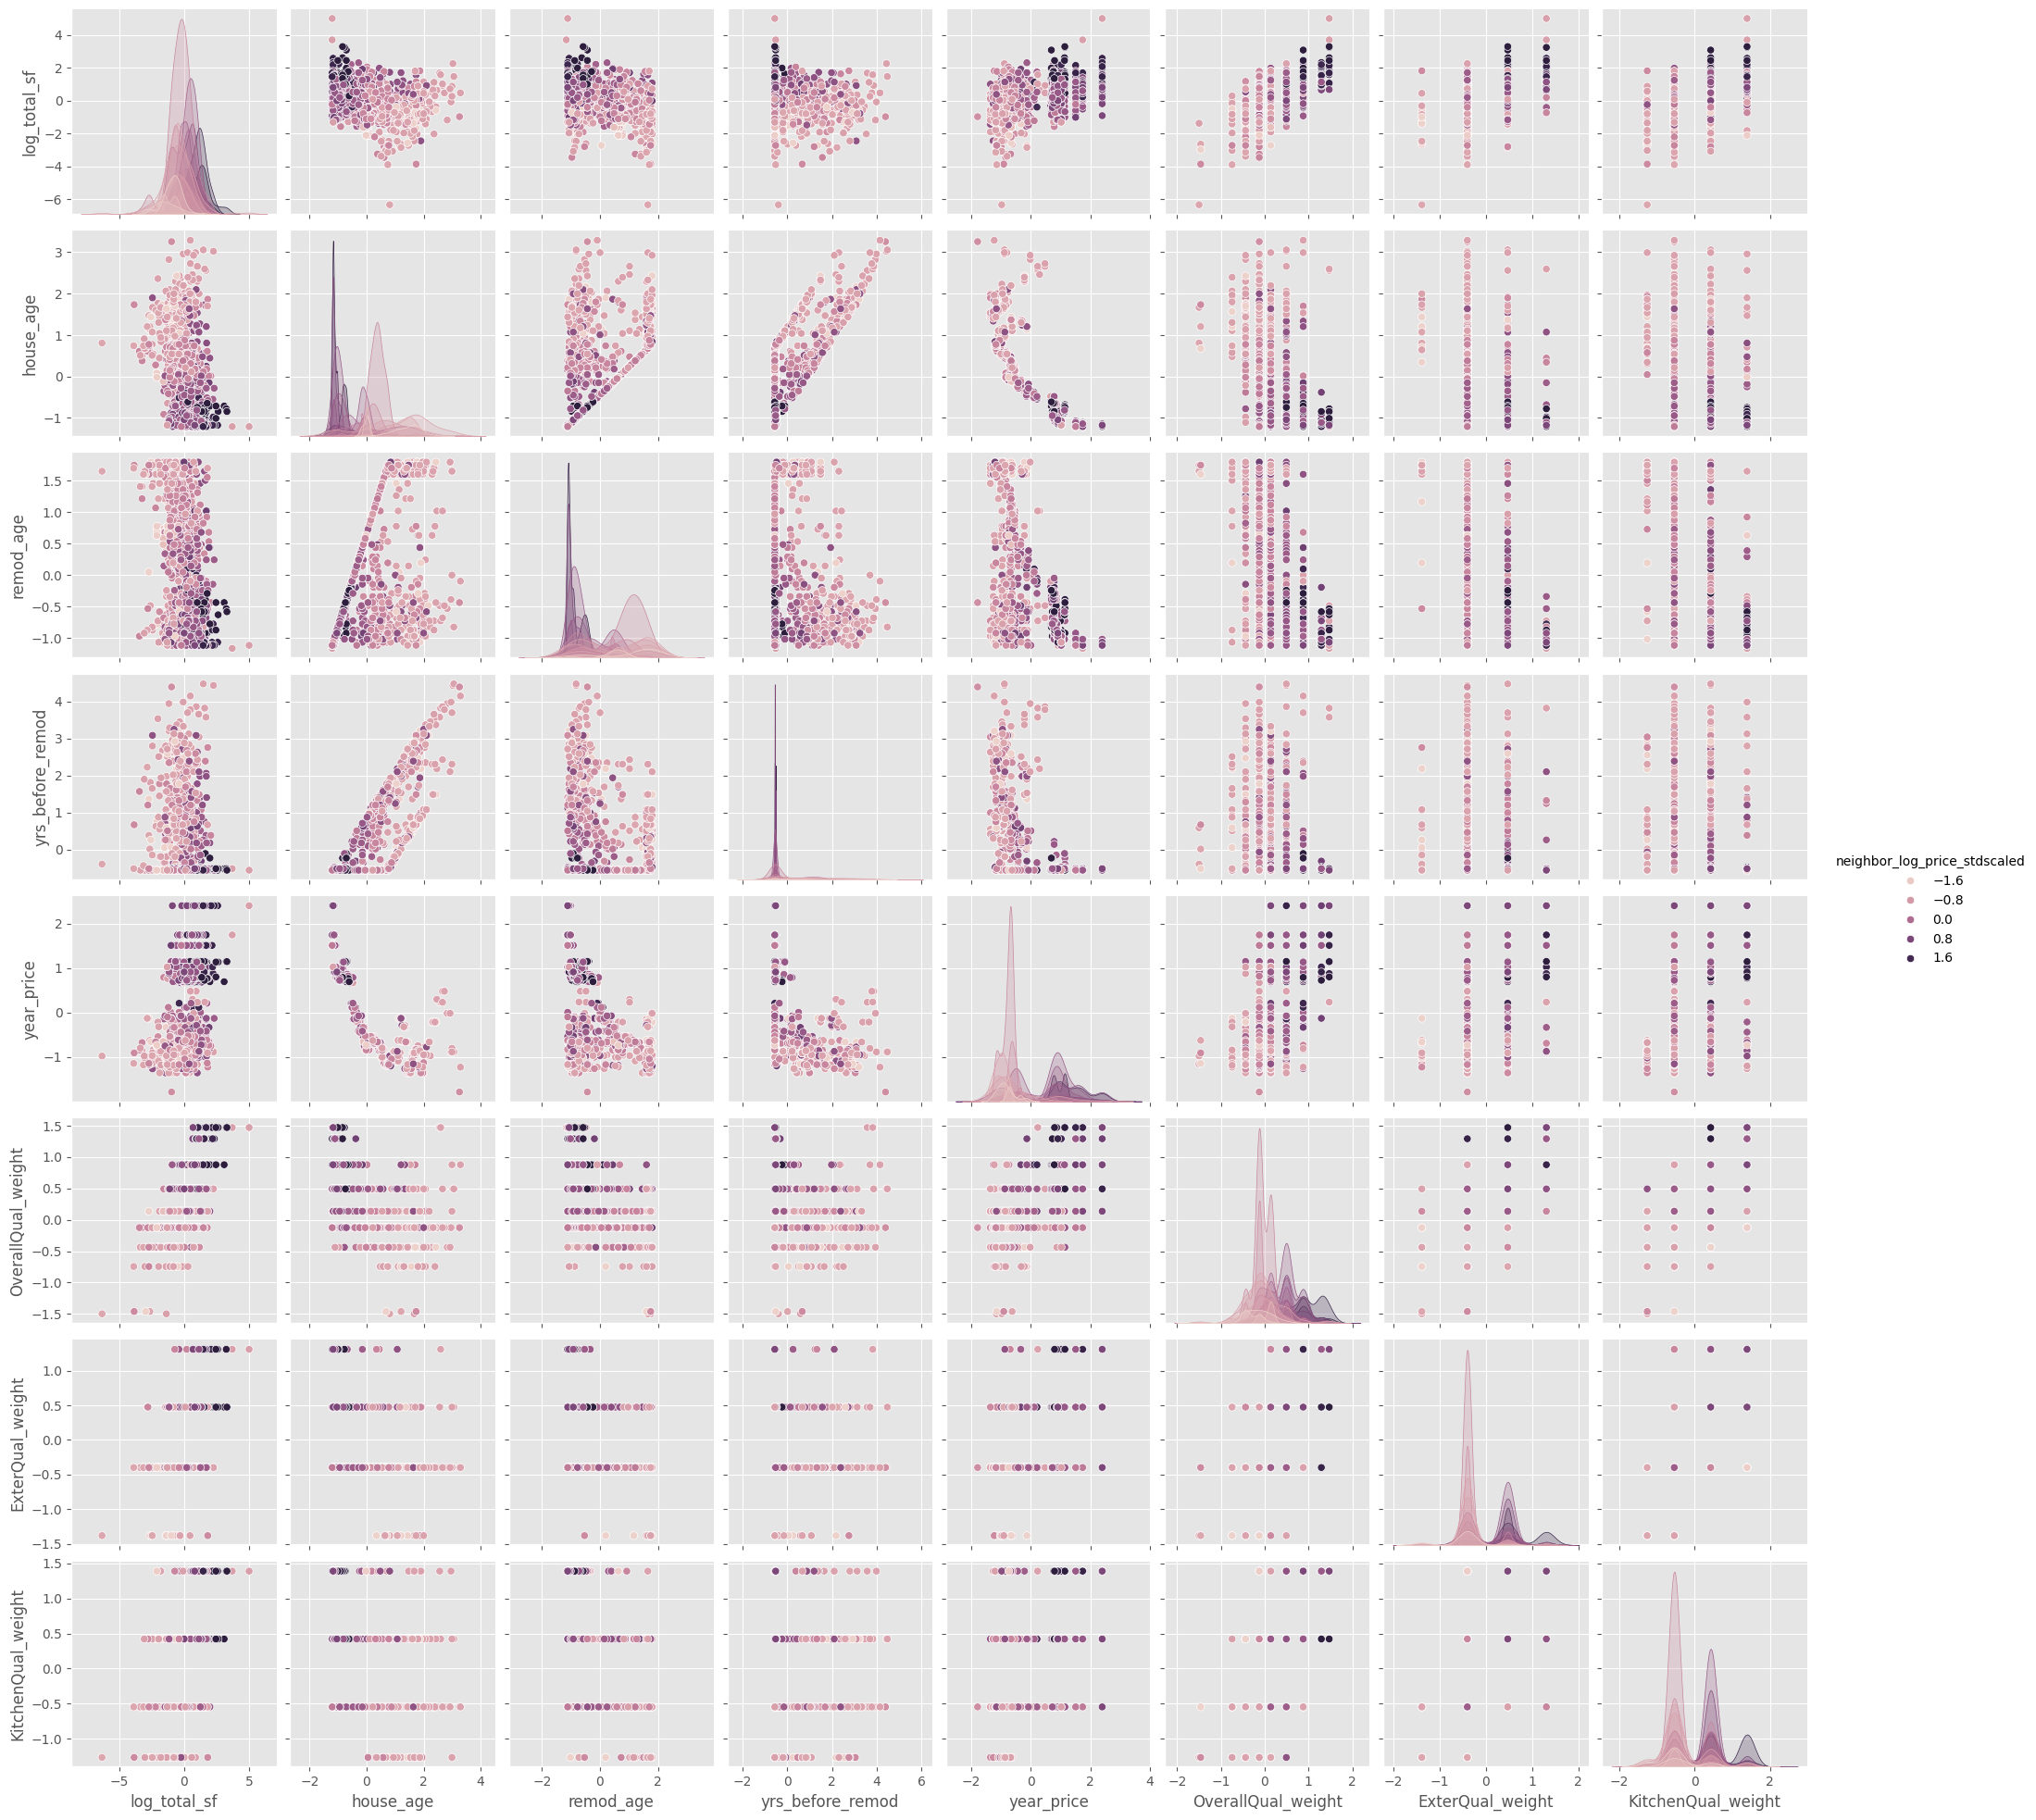

In [13]:
num_cols = [
    'log_total_sf',
    'house_age', 'remod_age', 'yrs_before_remod', 'year_price',
    'OverallQual_weight', 'ExterQual_weight', 'KitchenQual_weight',
    'neighbor_log_price_stdscaled']

sns.pairplot(data=data[num_cols], diag_kind='kde', hue='neighbor_log_price_stdscaled')
plt.show()

In [14]:
quality = data['OverallQual_weight']
size = data['log_total_sf']
location = data['neighbor_log_price_stdscaled']

# 通常の相関（立地の効果を考慮しない）
corr_qs = np.corrcoef(quality, size)[0, 1]
print(f"品質と広さの相関: {corr_qs:.4f}")

# 部分相関（立地の効果を制御）
pcorr_qs_given_l = pg.partial_corr(data=data, x='OverallQual_weight', y='log_total_sf', covar='neighbor_log_price_stdscaled')
hdi = pcorr_qs_given_l['CI95%'].iloc[0]
print(f"立地を条件とした品質と広さの部分相関（95%信頼区間）: {hdi[0]}~{hdi[1]}")

print(f'相関減少率: {((corr_qs- hdi[1])/corr_qs*100).round(2)}~{((corr_qs - hdi[0])/corr_qs*100).round(2)}%')

品質と広さの相関: 0.6799
立地を条件とした品質と広さの部分相関（95%信頼区間）: 0.45~0.53
相関減少率: 22.04~33.81%


### 解釈
品質と広さの関係の約22.0~33.8%が立地によって説明されるが、残りの7割程度は立地以外の要因による本質的な関連と考えられる。

同様に、キッチンと外装について、他の変数による媒介がないかを検証。

In [15]:
# 制御変数のリスト (例: 立地、広さ、築年数)
# control_vars = ['neighbor_log_price_stdscaled', 'log_total_sf', 'house_age', 'OverallQual_weight']
control_vars = [
    'log_total_sf',
    'house_age', 'remod_age',
    'OverallQual_weight',
    'neighbor_log_price_stdscaled']

corr_ke = np.corrcoef(data['KitchenQual_weight'], data['ExterQual_weight'])[0, 1]

for col in control_vars:
    partial_corr = pg.partial_corr(data=data, 
                                x='KitchenQual_weight', 
                                y='ExterQual_weight',
                                covar=col)
    hdi_ke = partial_corr['CI95%'].iloc[0]

    print(f'\nキッチンの外装の品質の相関: {corr_ke:.4f}')
    print(f'部分相関分析結果(95% HDI) given {col} = const: {hdi_ke[0]}~{hdi_ke[1]}')
    print(f'相関減少率: {((corr_ke- hdi_ke[1])/corr_ke*100).round(2)}~{((corr_ke - hdi_ke[0])/corr_ke*100).round(2)}%')


キッチンの外装の品質の相関: 0.7204
部分相関分析結果(95% HDI) given log_total_sf = const: 0.59~0.65
相関減少率: 9.78~18.1%

キッチンの外装の品質の相関: 0.7204
部分相関分析結果(95% HDI) given house_age = const: 0.56~0.63
相関減少率: 12.55~22.27%

キッチンの外装の品質の相関: 0.7204
部分相関分析結果(95% HDI) given remod_age = const: 0.52~0.59
相関減少率: 18.1~27.82%

キッチンの外装の品質の相関: 0.7204
部分相関分析結果(95% HDI) given OverallQual_weight = const: 0.4~0.48
相関減少率: 33.37~44.48%

キッチンの外装の品質の相関: 0.7204
部分相関分析結果(95% HDI) given neighbor_log_price_stdscaled = const: 0.52~0.59
相関減少率: 18.1~27.82%


とりあえずは、第三の変数によって完全に媒介されていなさそう。

## 3. 再度学習
重複する指標と重要でない指標を削除したデータセットで、新たに学習する

In [16]:
data_2 = data[important_cols]

X = data_2
y = target

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=66)

alpha = 1

ridge = Ridge(alpha=alpha)
ridge.fit(X_train, y_train)

y_pred = ridge.predict(X_val)

rmse = root_mean_squared_error(y_val, y_pred)

from sklearn.metrics import r2_score
r2 = r2_score(y_val, y_pred)

print(f"Ridge Regr. (alpha={alpha})")
print(f'RMSE: {rmse}')
print(r2)

Ridge Regr. (alpha=1)
RMSE: 0.16850426244198755
0.8203260420404501


In [17]:
metrics = {
    'model': 'Ridge (base)',
    'params': f'alpha={alpha}',
    'RMSE': round(rmse, 4),
    'R2': round(r2, 4)
}

metrics = pd.DataFrame(metrics, index=[0])

metrics.to_csv(os.path.join(METRICS_PATH, '0100_metrics.csv'))

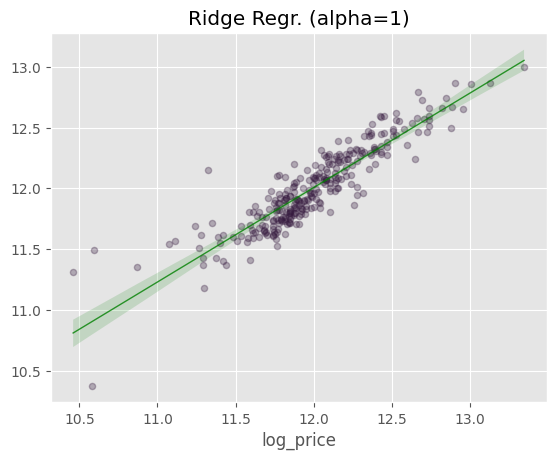

In [18]:
sns.regplot(x=y_val, y=y_pred, scatter_kws={'s': 20, 'alpha': 0.3}, line_kws={'color': 'green', 'lw': 1, 'alpha': 0.8})
plt.title(f"Ridge Regr. (alpha={alpha})")
plt.savefig(os.path.join(IMAGE_PATH, '0103_base_ridge.png'))
plt.show()

/Users/automatedtomato/github.com/automatedtomato/kaggle-house-prices/notebooks/utils/utils.py:113: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='importance', y='feature', data=importance, palette=colors)


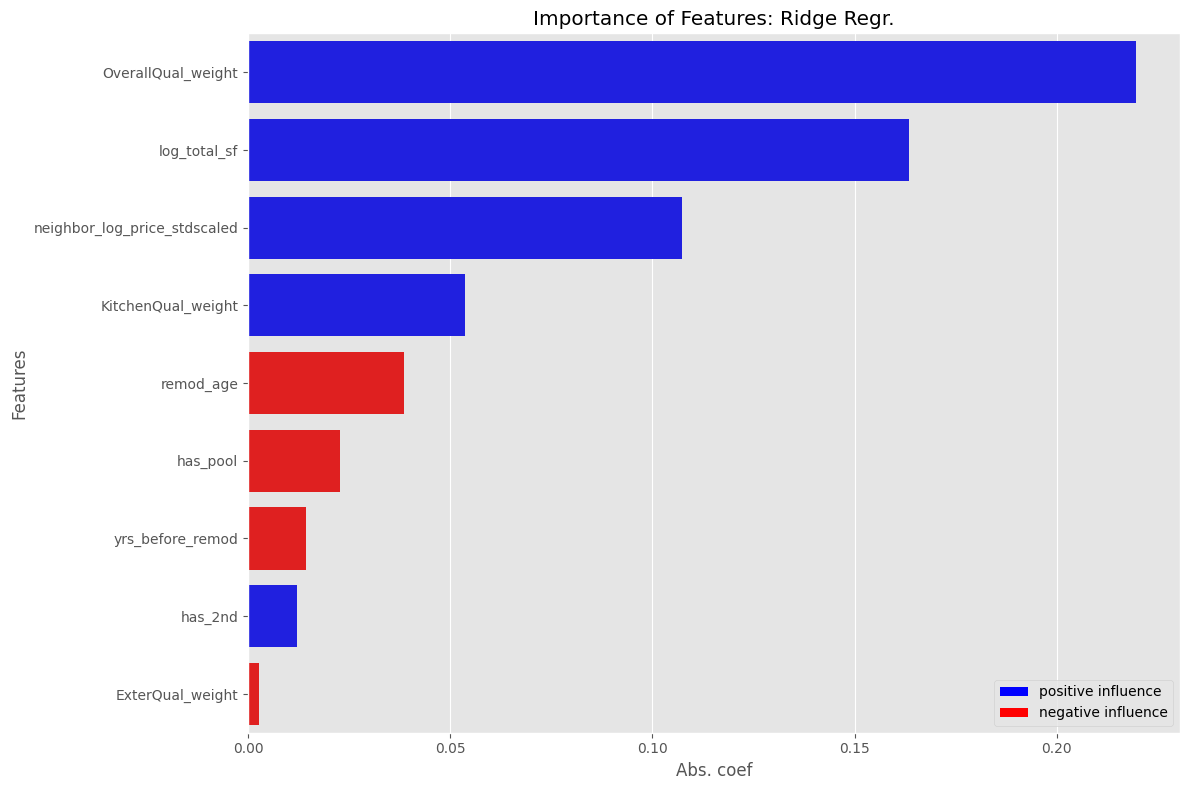

In [19]:
importance_df = plot_feature_importance(ridge, important_cols, 'coef', 'Importance of Features: Ridge Regr.')

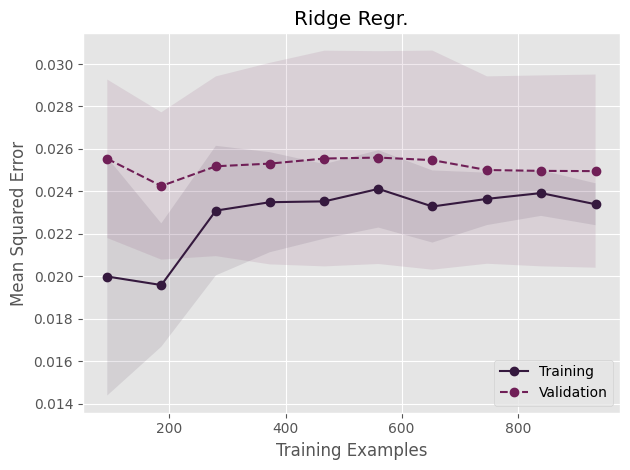

In [20]:
from utils import plot_learning_curve

plot_learning_curve(Ridge(alpha=1), X_train, y_train,'Ridge Regr.')

## 4. ベースラインモデル決定
- alpha=1のRidge回帰モデル
- 特徴量は以下の通り
    - 'log_total_sf': 広さ
    - 'remod_age', 'yrs_before_remod': 古さ（売買時の古さと、家そのものの古さ）
    - 'OverallQual_weight', 'ExterQual_weight', 'KitchenQual_weight': 家の品質
    - 'neighbor_log_price_stdscaled': 立地
    - 'has_2nd','has_pool': 2階の有無、プールの有無